### Sales Analyst

#### import necessary library

In [3]:
import os
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from itertools import combinations
from collections import Counter
from prophet import Prophet
import matplotlib.pyplot as plt

## Task 1 : merge all sales data into single file csv (Extract and transform data)

###### First Method : using glob package to get all file in directory

In [138]:
data_files = glob.glob('./Sales_data_five_years/*.csv')
all_data = pd.DataFrame()

for file in data_files:
    df=pd.read_csv(file)
    all_data = pd.concat([all_data,df])

all_data.to_csv('./Sales_data_five_years/Sales_data_five_years.csv',index=False)

###### Second Method : using listdir from os package to get all files in directory

In [140]:
data_files = [file for file in os.listdir("./Sales_data_five_years")]

all_data = pd.DataFrame()

for file in data_files:
    df=pd.read_csv("./Sales_data_five_years/"+file)
    all_data = pd.concat([all_data,df])

all_data.to_csv('./Sales_data_five_years/Sales_data_five_years.csv',index=False)

###### Uplaod and read the update data

In [4]:
Sales_data = pd.read_csv('./Sales_data_five_years/Sales_data_five_years.csv')
Sales_data.head(5)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,194482,Google phone,1,899,4/26/2019 22:31,"234 Al Andalous St, Casablanca, CAS 20000"
1,194483,Samsung phone,1,1199,4/6/2019 19:16,"914 Al Wahda St, Rabat, RAB 10000"
2,194484,Samsung phone,1,1199,4/30/2019 8:35,"468 Al Moukawama St, Salé, SAL 11000"
3,194485,iPhone,1,1099,4/30/2019 0:04,"22 Youssef Ibn Tachfine St, Tétouan, TET 93000"
4,194486,OnePlus phone,1,969,4/17/2019 21:59,"230 Oued Eddahab St, Tanger, TNG 90000"


## Task 2 : Clean the dataset

In [5]:
# size of my dataset
Sales_data.shape

(2252050, 6)

In [6]:
# Colonnes Types
Sales_data.dtypes

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
dtype: object

In [7]:
# Convert the data types of certain variables to float
Sales_data['Order ID'] = pd.to_numeric(Sales_data['Order ID'],errors='coerce')
Sales_data['Quantity Ordered'] = pd.to_numeric(Sales_data['Quantity Ordered'],errors='coerce')
Sales_data['Price Each'] = pd.to_numeric(Sales_data['Price Each'],errors='coerce')
Sales_data['Order Date'] = pd.to_datetime(Sales_data['Order Date'],errors='coerce')

In [8]:
#convert all NaN value to np.na
def convert_to_nan(df):
    n_col = df.shape[1] 
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

Sales_data = convert_to_nan(Sales_data)

<AxesSubplot:title={'center':'Messing values per features'}>

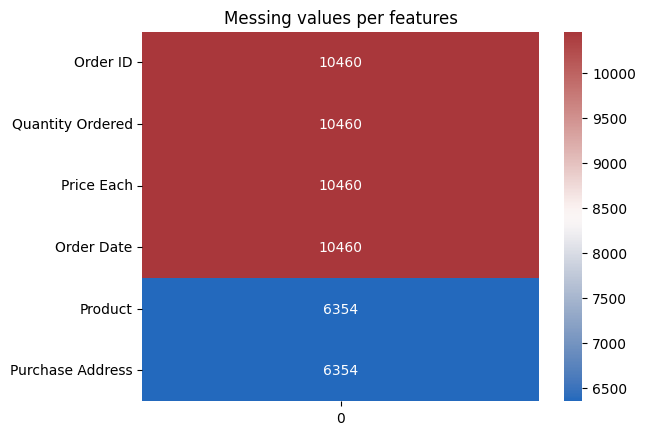

In [9]:
#Check for messing values
plt.title('Messing values per features')
nans = Sales_data.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

##### Remove all rows where we have all cols are empty (nan)

In [10]:
df_nan = Sales_data[(Sales_data['Order Date'].isna()) | (Sales_data['Product'].isna()) | (Sales_data['Price Each'].isna()) | (Sales_data['Purchase Address'].isna()) | (Sales_data['Quantity Ordered'].isna())]
df_nan_index = df_nan.index
df_nan

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
83,NaN,Product,NaN,NaN,NaT,Purchase Address
360,NaN,Product,NaN,NaN,NaT,Purchase Address
777,NaN,Product,NaN,NaN,NaT,Purchase Address
1274,NaN,NaN,NaN,NaN,NaT,NaN
1277,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...
2251493,NaN,NaN,NaN,NaN,NaT,NaN
2251633,NaN,Product,NaN,NaN,NaT,Purchase Address
2251716,NaN,NaN,NaN,NaN,NaT,NaN
2251987,NaN,NaN,NaN,NaN,NaT,NaN


In [11]:
Sales_data.drop(df_nan_index,axis=0,inplace=True)

<AxesSubplot:title={'center':'Messing Value per feature'}>

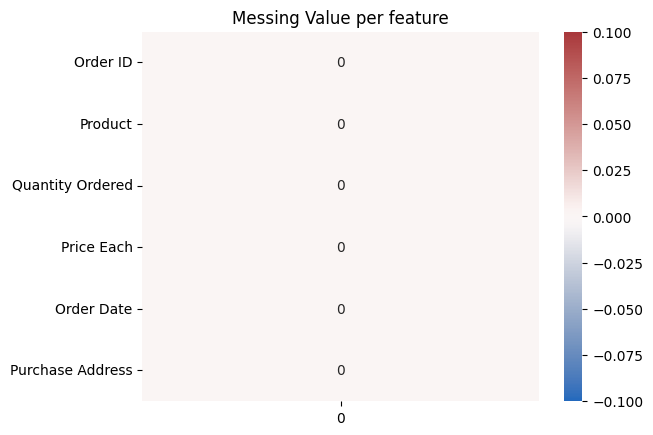

In [12]:
plt.title('Messing Value per feature')
nans = Sales_data.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

## Task 3 : Add some cols to data

In [13]:
# Extract month, year, and day into separate columns
Sales_data['Month'] = Sales_data['Order Date'].dt.month
Sales_data['Year'] = Sales_data['Order Date'].dt.year
Sales_data['Day'] = Sales_data['Order Date'].dt.day

In [14]:
# Extracting the city and the street from the address
Sales_data['Street'] = Sales_data['Purchase Address'].str.split(",").str[0].str.strip()
Sales_data['City'] = Sales_data['Purchase Address'].str.split(",").str[1].str.strip()

## Task 4 : Add sales column

In [15]:
Sales_data['Sales'] = Sales_data['Price Each'] * Sales_data['Quantity Ordered']
Sales_data.head(2)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Year,Day,Street,City,Sales
0,194482.0,Google phone,1.0,899.0,2019-04-26 22:31:00,"234 Al Andalous St, Casablanca, CAS 20000",4,2019,26,234 Al Andalous St,Casablanca,899.0
1,194483.0,Samsung phone,1.0,1199.0,2019-04-06 19:16:00,"914 Al Wahda St, Rabat, RAB 10000",4,2019,6,914 Al Wahda St,Rabat,1199.0


## Task 5 : Data Exploration!

#### Question 1 : What was the best month for sales ? how much was earned that month ?

In [16]:
Sales_data.groupby(['Month','Year']).sum().head(6)

Order ID  Quantity Ordered   Price Each     Day        Sales
Month Year                                                                  
1     2019  5.860193e+09           39298.0  40615225.24  623040  40638897.00
      2020  4.480543e+09           28564.0  29640797.34  456182  29664951.80
      2021  7.669497e+09           44932.0  46424719.46  717856  46475385.46
      2022  6.877017e+09           39644.0  41243267.76  629010  41286300.20
      2023  9.756332e+09           50116.0  51901306.34  796956  51936494.08
      2024  3.666795e+07              86.0     86545.74      86     86545.74

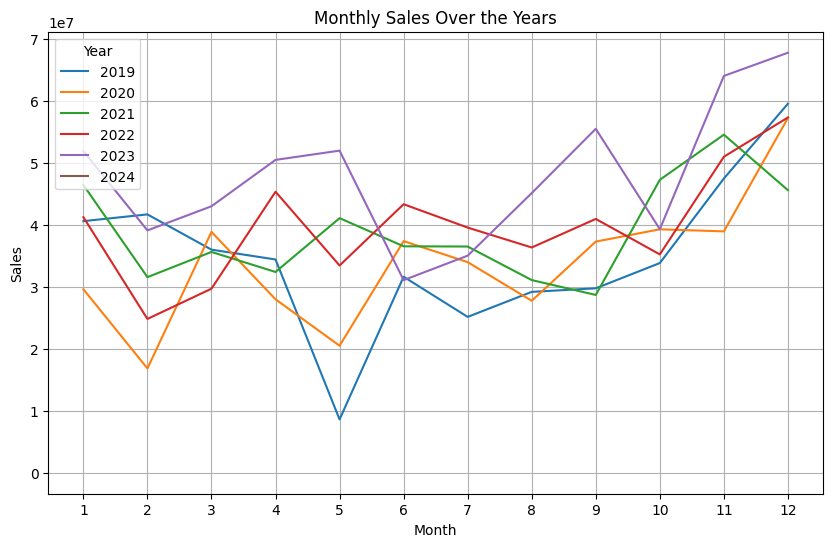

In [17]:
# Group the data by 'Month' and 'Year' and sum the values
monthly_sales = Sales_data.groupby(['Month', 'Year']).sum()

# Reset the index to make 'Month' and 'Year' as columns again
monthly_sales = monthly_sales.reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for year in monthly_sales['Year'].unique():
    data = monthly_sales[monthly_sales['Year'] == year]
    plt.plot(data['Month'], data['Sales'], label=str(year))

# Customize the plot
plt.title('Monthly Sales Over the Years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(range(1, 13))
plt.legend(title='Year', loc='upper left')
plt.grid(True)

# Show the plot
plt.show()


#### Question 2 : What's the year when we had a heighest number of Sales ?

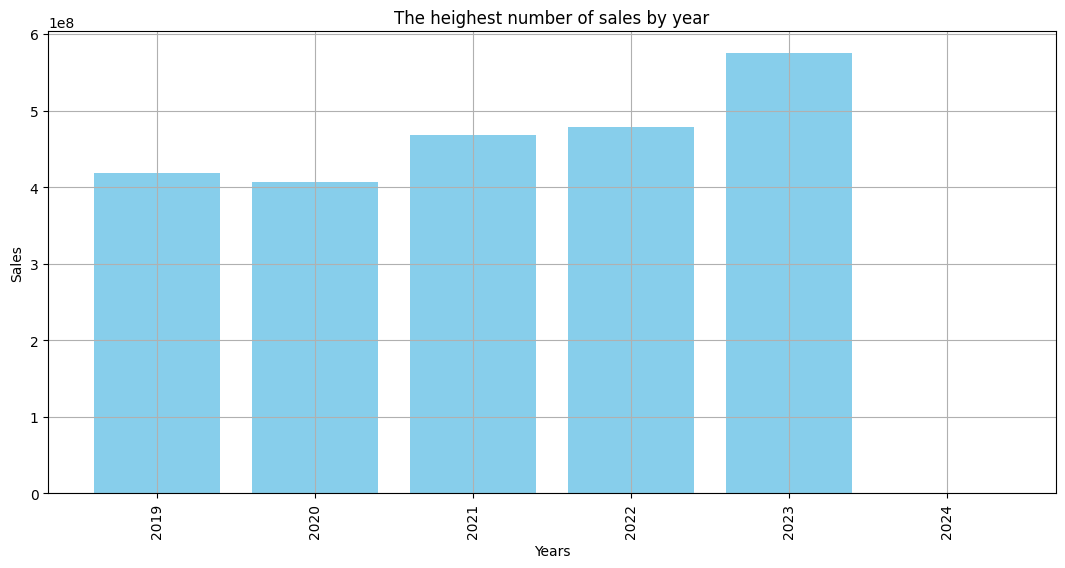

In [32]:
City_sales = Sales_data.groupby('Year').sum()
City_sales = City_sales.reset_index()

plt.figure(figsize=(13,6))
plt.bar(City_sales['Year'],City_sales['Sales'], color='skyblue')

plt.title("The heighest number of sales by year")
plt.xlabel("Years")
plt.ylabel("Sales")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()



#### Question 3 : What products are most often sold together ?

In [31]:
df = Sales_data[Sales_data['Order ID'].duplicated(keep=False)]
df['Group'] = df.groupby('Order ID')['Product'].transform(lambda x: ",".join(x))
new_df = df[['Order ID','Group']].drop_duplicates()
new_df.head(5)

,Order ID,Group
0,194482.0,"Google phone,Huawei phone,Samsung phone,Samsun..."
1,194483.0,"Samsung phone,Xiaomi phone,Xiaomi phone,Google..."
2,194484.0,"Samsung phone,Huawei phone,iPhone,Wired Headph..."
3,194485.0,"iPhone,Sony phone,Apple Airpods Headphones,iPh..."
4,194486.0,"OnePlus phone,Huawei phone,Samsung phone,iPhon..."


In [33]:
count = Counter()

for row in new_df['Group']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key,value in count.most_common(10):
    print(key, value)


('Sony phone', 'Sony phone') 383512
('Samsung phone', 'Samsung phone') 357893
('iPhone', 'iPhone') 356208
('Huawei phone', 'Huawei phone') 303058
('Xiaomi phone', 'Xiaomi phone') 234479
('OnePlus phone', 'OnePlus phone') 223733
('Sony phone', 'Samsung phone') 195833
('Samsung phone', 'Sony phone') 195099
('Sony phone', 'iPhone') 194658
('iPhone', 'Sony phone') 194566


#### Question 4 : What product sold the most? Why do you think it sold the most?

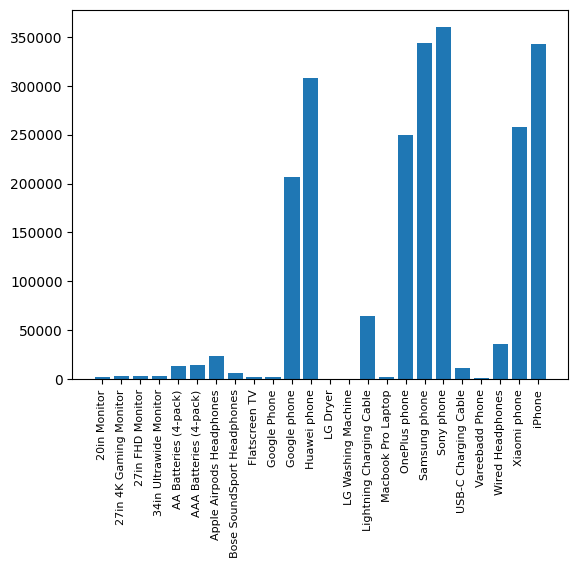

In [34]:
product_group = Sales_data.groupby('Product')
quantity_ordered = product_group.sum()['Quantity Ordered']

products = [product for product, df in product_group]
plt.bar(products, quantity_ordered)
plt.xticks(products, rotation='vertical', size=8)
plt.show()

C:\Users\amine\AppData\Local\Temp\ipykernel_17196\1440977694.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(products, rotation=90, size=12)


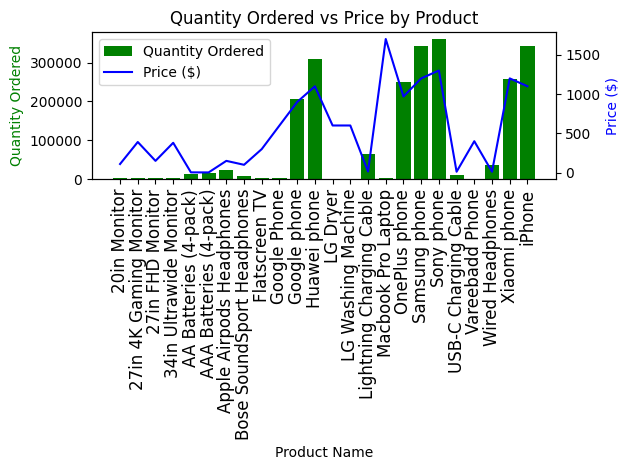

In [35]:
prices = Sales_data.groupby('Product').mean()['Price Each'].copy()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(products, quantity_ordered, color='g', label='Quantity Ordered')
ax2.plot(products, prices, color='b', label='Price ($)')

ax1.set_xlabel('Product Name')
ax1.set_ylabel('Quantity Ordered', color='g')
ax2.set_ylabel('Price ($)', color='b')
ax1.set_xticklabels(products, rotation=90, size=12)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Quantity Ordered vs Price by Product')

plt.tight_layout()
plt.show()


#### Question 5 : Overall trend in sales over the given period 

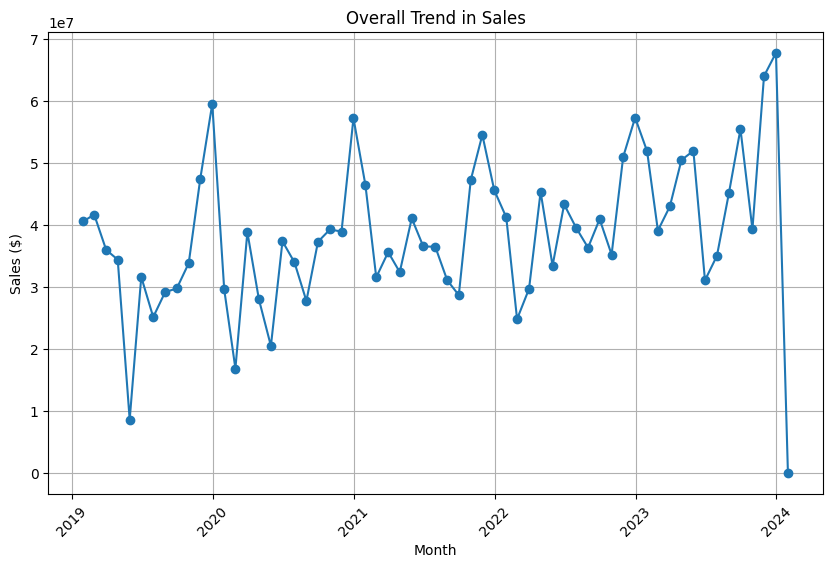

In [36]:
sales_data = Sales_data
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])
monthly_sales = sales_data.groupby(pd.Grouper(key='Order Date', freq='M')).sum()['Sales']

# Plotting the overall trend in sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-')
plt.title('Overall Trend in Sales')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Question 6 : Top selling products by quantity ordered and revenue generated

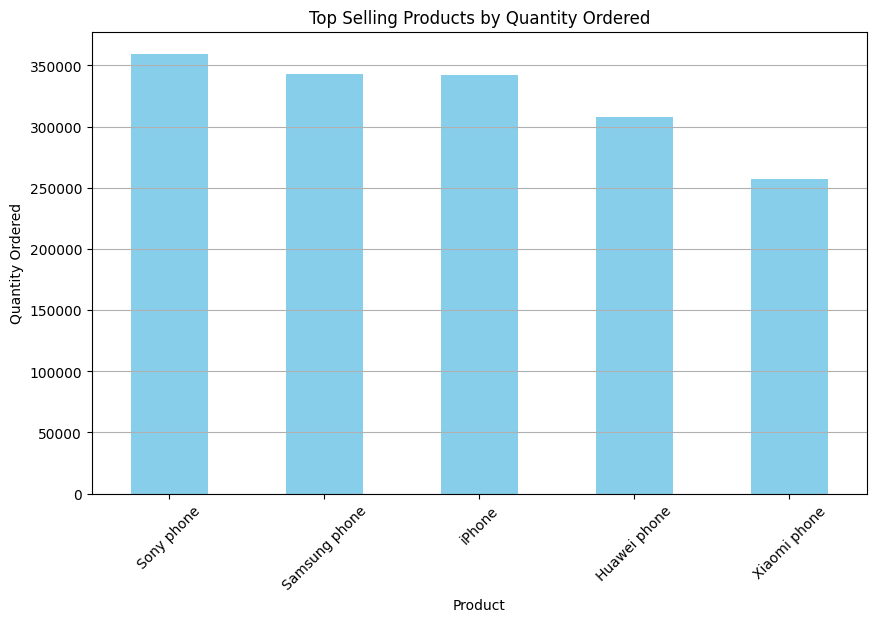

In [37]:
top_products_quantity = sales_data.groupby('Product').sum()['Quantity Ordered'].sort_values(ascending=False).head(5)
top_products_revenue = sales_data.groupby('Product').sum()['Sales'].sort_values(ascending=False).head(5)

# Plotting top selling products by quantity ordered
plt.figure(figsize=(10, 6))
top_products_quantity.plot(kind='bar', color='skyblue')
plt.title('Top Selling Products by Quantity Ordered')
plt.xlabel('Product')
plt.ylabel('Quantity Ordered')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

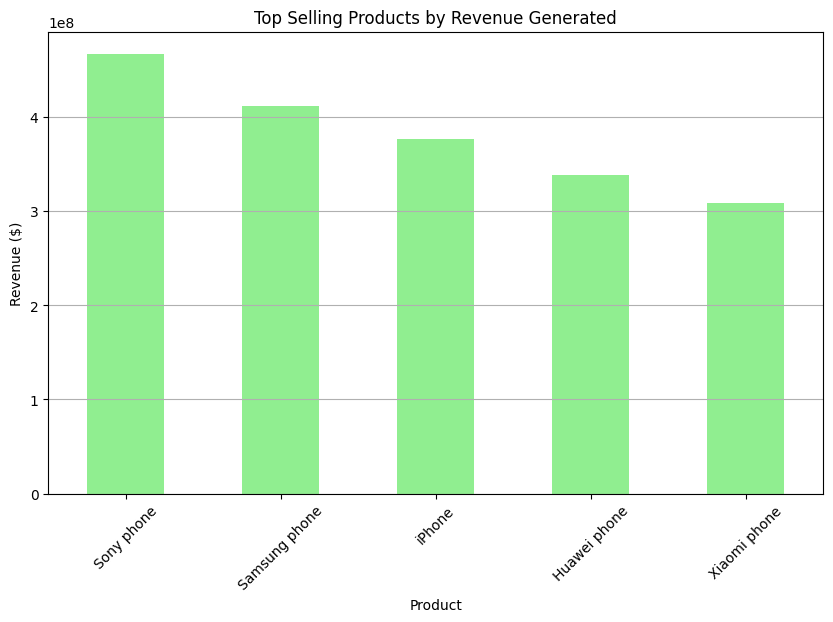

In [38]:
# Plotting top selling products by revenue generated
plt.figure(figsize=(10, 6))
top_products_revenue.plot(kind='bar', color='lightgreen')
plt.title('Top Selling Products by Revenue Generated')
plt.xlabel('Product')
plt.ylabel('Revenue ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### Question 8 : Correlation between price of a product and quantity ordered

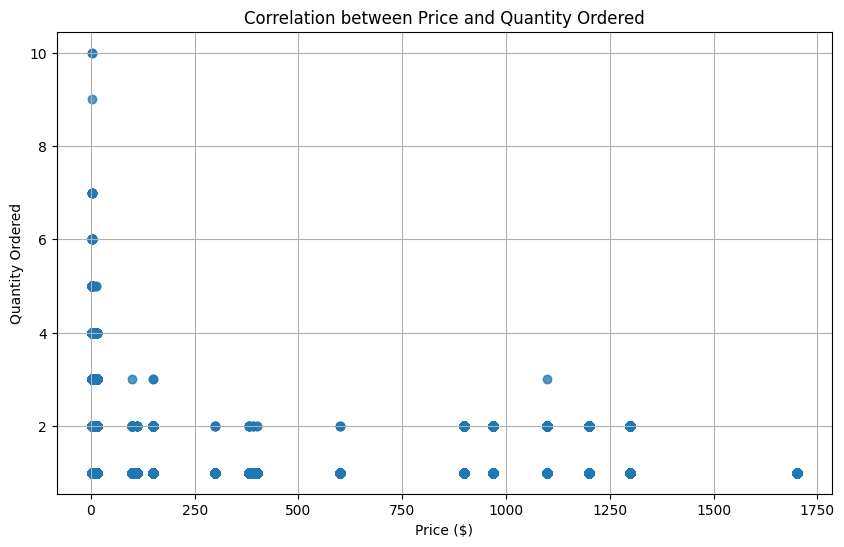

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(sales_data['Price Each'], sales_data['Quantity Ordered'], alpha=0.5)
plt.title('Correlation between Price and Quantity Ordered')
plt.xlabel('Price ($)')
plt.ylabel('Quantity Ordered')
plt.grid(True)
plt.show()

#### Question 9 : Peak sales months throughout the year

In [40]:
monthly_sales.idxmax()

Timestamp('2023-12-31 00:00:00', freq='M')

#### Question 10 : Sales performance across different cities

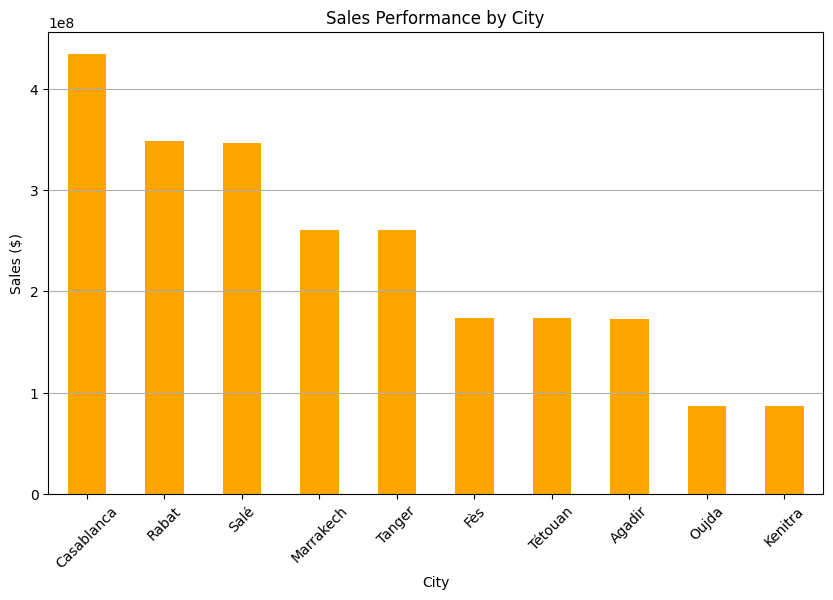

In [41]:
city_sales = sales_data.groupby('City').sum()['Sales'].sort_values(ascending=False)

# Plotting sales performance across different cities
plt.figure(figsize=(10, 6))
city_sales.plot(kind='bar', color='orange')
plt.title('Sales Performance by City')
plt.xlabel('City')
plt.ylabel('Sales ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### Question 11 : Forcasting Sales for casablanca city in the next 4 months 

In [42]:
casablanca_sales = Sales_data[Sales_data['City'] == 'Casablanca'].copy()
casablanca_sales['Order Date'] = casablanca_sales['Order Date'].dt.date
daily_sales_casablanca = casablanca_sales.groupby('Order Date')['Sales'].sum().reset_index()

In [53]:
# Rename the columns
daily_sales_casablanca = daily_sales_casablanca.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(daily_sales_casablanca)

# Make future predictions
future_dates = model.make_future_dataframe(periods=120)  # Next 30 days
forecast = model.predict(future_dates)

# Display the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7))  # Last 7 rows (next 30 days)

17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing


             ds           yhat     yhat_lower     yhat_upper
1939 2024-04-24  304613.819338  239685.124387  364712.933653
1940 2024-04-25  303007.792901  245826.438465  364813.035852
1941 2024-04-26  299678.294075  234916.363232  355401.631688
1942 2024-04-27  298475.341769  239125.371608  361243.638835
1943 2024-04-28  292633.480139  229550.458702  356852.397158
1944 2024-04-29  291307.101700  229968.757866  352474.894452
1945 2024-04-30  286978.491476  227234.889588  346435.642010


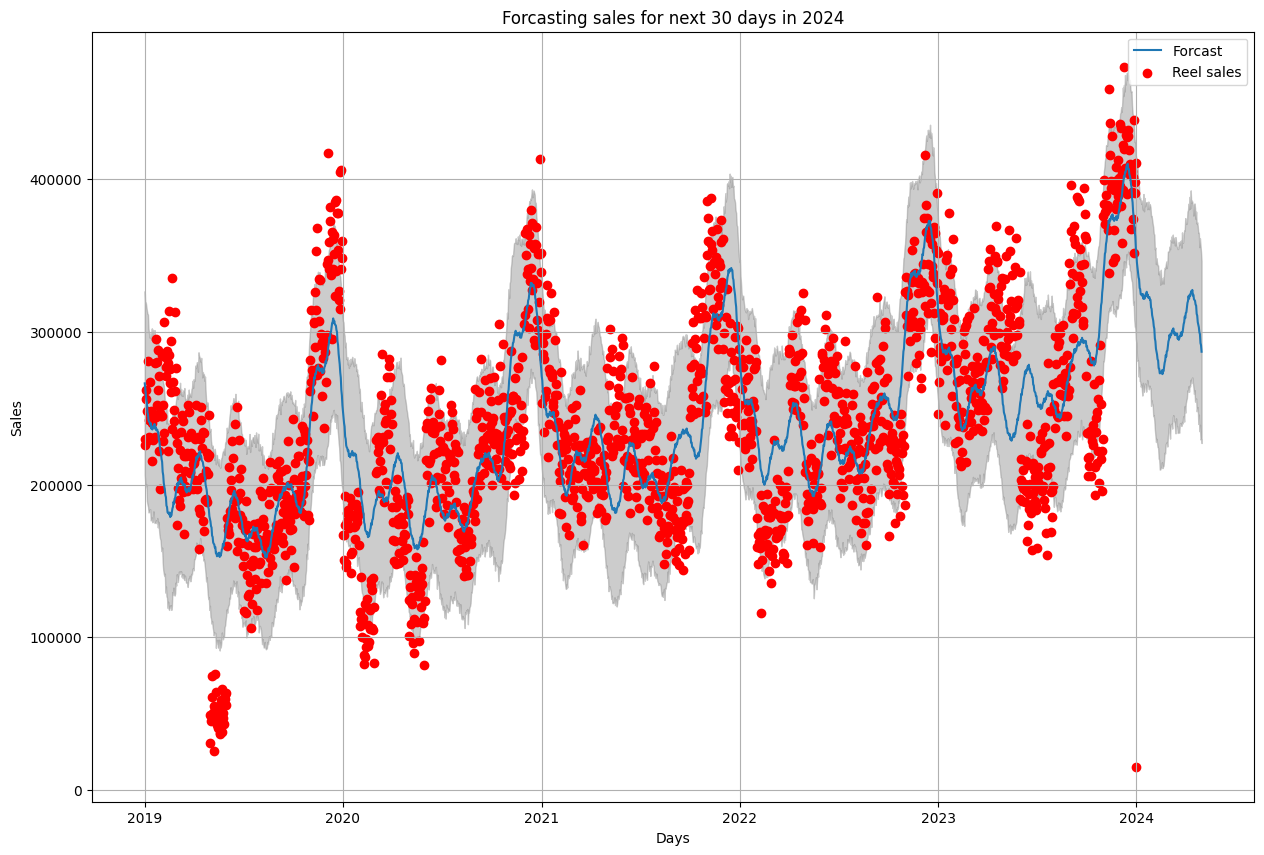

In [54]:
plt.figure(figsize=(15,10))
plt.title("Forcasting sales for next 4 months in 2024")
plt.plot(forecast['ds'], forecast['yhat'], label='Forcast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.4)
plt.scatter(daily_sales_casablanca['ds'], daily_sales_casablanca['y'], color='red', label='Reel sales')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Sales")
plt.grid(True)
plt.show()